In [ ]:
!pip install ray

In [ ]:
import colorsys
import ray
import matplotlib.pyplot as plt
import numpy as np
from ray.util import ActorPool

In [ ]:
ray.init()

# Animation parameters
FPS = 30
NUM_SEC = 30
ZOOM_RATE = 0.99

# Image parameters
XY_PROP = 3/2
Y_DIM = 512
X_DIM = int(XY_PROP * Y_DIM)
IMG_DIM = (X_DIM, Y_DIM)

# Complex plane parameters
CENTER = (-0.7845, -0.1272)
Y_LENGTH = 2
X_LENGTH = XY_PROP * Y_LENGTH

def get_windows(scale=1):
    x_window = [CENTER[0] - scale * X_LENGTH / 2, 
                CENTER[0] + scale * X_LENGTH / 2]
    y_window = [CENTER[1] - scale * Y_LENGTH / 2, 
                CENTER[1] + scale * Y_LENGTH / 2]
    return x_window, y_window

def rgb_conv(i):
    color = 255 * np.array(colorsys.hsv_to_rgb(i / 255.0, 1.0, 0.5))
    return tuple(color.astype(int))

def mandelbrot(x, y):
    c, z = complex(x, y), 0
    for i in range(1000):
        if abs(z) > 2:
            return rgb_conv(i)
        z = z * z + c
    return (0, 0, 0)

In [3]:
@ray.remote
class FractalActor:
    MAX_ITER = 1000
    
    def get_frame(self, frame_num):
        x_window, y_window = get_windows(scale=ZOOM_RATE ** frame_num)
        print(x_window, y_window)
        
        pixels = np.zeros((Y_DIM, X_DIM, 3), int)

        x = np.linspace(x_window[0], x_window[1], IMG_DIM[0]).reshape(1, IMG_DIM[0])
        y = np.linspace(y_window[0], y_window[1], IMG_DIM[1]).reshape(IMG_DIM[1], 1)

        c = x + 1j * y
        z = np.zeros(c.shape, dtype=np.complex128)
        
        iterations = np.zeros(z.shape, dtype=np.uint8)
        active = np.full(c.shape, True, dtype=bool)

        for i in range(self.MAX_ITER):
            z[active] = z[active]**2 + c[active]
            
            diverged = np.greater(np.abs(z), 2.236, out=np.full(c.shape, False), where=active)
            iterations[diverged] = i
            active[np.abs(z) > 2.236] = False
        iterations[active] = self.MAX_ITER + 1
        return frame_num, iterations

In [ ]:
# Get just one frame to make sure everything looks good
a = FractalActor.remote()
frame_num, frame = ray.get(a.get_frame.remote(FPS * NUM_SEC))
plt.imshow(frame)

In [4]:
%%capture

# Create a pool of actors, one per CPU core
actors = []
for actor in range(int(ray.cluster_resources()['CPU'])):
    actors.append(FractalActor.remote())
pool = ActorPool(actors)

In [5]:
num_frames = FPS * NUM_SEC
frames = np.zeros((num_frames, Y_DIM, X_DIM), int)

# Evaluate all frames
for frame_num, frame in pool.map_unordered(
    lambda a, v: a.get_frame.remote(v), list(range(num_frames))):
    frames[frame_num] = frame

(pid=53090) [-2.2845, 0.7155] [-1.1272, 0.8728]
(pid=53098) [-2.1967202241015, 0.6277202241015001] [-1.068680149401, 0.814280149401]
(pid=53089) [-2.2399485, 0.6709485000000002] [-1.097499, 0.843099]
(pid=53094) [-2.1825980218604846, 0.6135980218604848] [-1.05926534790699, 0.8048653479069899]
(pid=53088) [-2.225394015, 0.656394015] [-1.08779601, 0.83339601]
(pid=53092) [-2.25465, 0.6856499999999999] [-1.1073, 0.8529]
(pid=53091) [-2.2695, 0.7004999999999999] [-1.1172, 0.8628]
(pid=53095) [-2.21098507485, 0.64198507485] [-1.0781900499, 0.8237900498999999]
(pid=53093) [-2.1410731125132063, 0.5720731125132066] [-1.0315820750088045, 0.7771820750088044]
(pid=53096) [-2.1547758712254614, 0.5857758712254613] [-1.0407172474836408, 0.7863172474836408]
(pid=53097) [-2.16861704164188, 0.59961704164188] [-1.04994469442792, 0.7955446944279201]
(pid=53112) [-2.1275073813880745, 0.5585073813880745] [-1.0225382542587165, 0.7681382542587164]
(pid=53090) [-2.1140773075741937, 0.5450773075741939] [-1.013

(pid=53094) [-1.4694146216158717, -0.09958537838412829] [-0.5838097477439145, 0.3294097477439145]
(pid=53098) [-1.462565475399713, -0.1064345246002869] [-0.5792436502664754, 0.3248436502664753]
(pid=53097) [-1.4557848206457158, -0.11321517935428405] [-0.5747232137638106, 0.32032321376381057]
(pid=53096) [-1.4490719724392587, -0.11992802756074128] [-0.5702479816261725, 0.31584798162617245]
(pid=53112) [-1.4424262527148661, -0.12657374728513382] [-0.5658175018099108, 0.3114175018099108]
(pid=53093) [-1.4358469901877173, -0.1331530098122825] [-0.5614313267918116, 0.30703132679181167]
(pid=53092) [-1.4293335202858404, -0.13966647971415969] [-0.5570890135238935, 0.30268901352389355]
(pid=53091) [-1.4228851850829818, -0.14611481491701805] [-0.5527901233886546, 0.29839012338865456]
(pid=53088) [-1.4165013332321519, -0.15249866676784796] [-0.548534222154768, 0.29413422215476803]
(pid=53090) [-1.4101813198998305, -0.15881868010016942] [-0.5443208799332203, 0.28992087993322035]
(pid=53089) [-1.4

(pid=53097) [-1.1100673450092113, -0.4589326549907886] [-0.34424489667280755, 0.08984489667280757]
(pid=53096) [-1.1068116715591192, -0.46218832844088076] [-0.34207444770607953, 0.08767444770607949]
(pid=53112) [-1.103588554843528, -0.4654114451564719] [-0.3399257032290187, 0.0855257032290187]
(pid=53093) [-1.1003976692950928, -0.4686023307049072] [-0.3377984461967285, 0.08339844619672851]
(pid=53092) [-1.0972386926021418, -0.4717613073978581] [-0.33569246173476125, 0.08129246173476123]
(pid=53091) [-1.0941113056761202, -0.4748886943238796] [-0.33360753711741364, 0.0792075371174136]
(pid=53088) [-1.0910151926193592, -0.47798480738064075] [-0.3315434617462395, 0.07714346174623948]
(pid=53090) [-1.0879500406931655, -0.48104995930683436] [-0.32950002712877713, 0.07510002712877709]
(pid=53089) [-1.084915540286234, -0.484084459713766] [-0.3274770268574893, 0.07307702685748929]
(pid=53095) [-1.0819113848833717, -0.4870886151166283] [-0.32547425658891443, 0.07107425658891442]
(pid=53094) [-1.

(pid=53112) [-0.939255195452365, -0.6297448045476349] [-0.23037013030157671, -0.024029869698423315]
(pid=53093) [-0.9377076434978413, -0.6312923565021586] [-0.22933842899856094, -0.02506157100143909]
(pid=53092) [-0.936175567062863, -0.632824432937137] [-0.22831704470857533, -0.026082955291424695]
(pid=53088) [-0.9346588113922343, -0.6343411886077657] [-0.22730587426148957, -0.027094125738510458]
(pid=53091) [-0.933157223278312, -0.635842776721688] [-0.22630481551887466, -0.028095184481125343]
(pid=53090) [-0.9316706510455288, -0.6373293489544711] [-0.2253137673636859, -0.029086232636314102]
(pid=53089) [-0.9301989445350736, -0.6388010554649264] [-0.22433262969004905, -0.030067370309950964]
(pid=53095) [-0.9287419550897228, -0.6402580449102772] [-0.22336130339314858, -0.03103869660685145]
(pid=53094) [-0.9272995355388256, -0.6417004644611743] [-0.22239969035921708, -0.03200030964078293]
(pid=53098) [-0.9258715401834373, -0.6431284598165626] [-0.22144769345562493, -0.0329523065443751]
(

(pid=53092) [-0.8580613411069286, -0.7109386588930714] [-0.17624089407128574, -0.07815910592871428]
(pid=53088) [-0.8573257276958592, -0.7116742723041407] [-0.17575048513057287, -0.07864951486942715]
(pid=53091) [-0.8565974704189007, -0.7124025295810993] [-0.17526498027926715, -0.07913501972073286]
(pid=53089) [-0.8558764957147117, -0.7131235042852883] [-0.17478433047647446, -0.07961566952352554]
(pid=53090) [-0.8551627307575645, -0.7138372692424354] [-0.17430848717170971, -0.08009151282829029]
(pid=53095) [-0.8544561034499889, -0.714543896550011] [-0.17383740229999262, -0.08056259770000739]
(pid=53094) [-0.853756542415489, -0.7152434575845109] [-0.1733710282769927, -0.08102897172300731]
(pid=53098) [-0.8530639769913342, -0.7159360230086658] [-0.17290931799422277, -0.08149068200577725]
(pid=53097) [-0.8523783372214208, -0.7166216627785792] [-0.17245222481428055, -0.08194777518571947]
(pid=53096) [-0.8516995538492066, -0.7173004461507934] [-0.17199970256613775, -0.08240029743386226]
(pi

(pid=53088) [-0.8198198494664278, -0.7491801505335721] [-0.1507465663109519, -0.10365343368904811]
(pid=53089) [-0.819116984462046, -0.749883015537954] [-0.15027798964136396, -0.10412201035863605]
(pid=53091) [-0.8194666509717635, -0.7495333490282364] [-0.1505111006478424, -0.10388889935215763]
(pid=53090) [-0.8187708146174254, -0.7502291853825745] [-0.15004720974495034, -0.10435279025504969]
(pid=53095) [-0.8184281064712512, -0.7505718935287488] [-0.1498187376475008, -0.10458126235249919]
(pid=53094) [-0.8180888254065387, -0.7509111745934612] [-0.1495925502710258, -0.1048074497289742]
(pid=53098) [-0.8177529371524733, -0.7512470628475266] [-0.14936862476831556, -0.10503137523168446]
(pid=53097) [-0.8174204077809486, -0.7515795922190514] [-0.1491469385206324, -0.10525306147936761]
(pid=53096) [-0.817091203703139, -0.7519087962968609] [-0.14892746913542607, -0.10547253086457394]
(pid=53093) [-0.8167652916661077, -0.7522347083338923] [-0.14871019444407182, -0.1056898055559282]
(pid=53112

(pid=53091) [-0.8012889387290071, -0.7677110612709929] [-0.13839262581933806, -0.11600737418066197]
(pid=53090) [-0.801121049341717, -0.7678789506582829] [-0.13828069956114467, -0.11611930043885535]
(pid=53095) [-0.8009548388482998, -0.7680451611517002] [-0.13816989256553322, -0.1162301074344668]
(pid=53098) [-0.8007902904598168, -0.7682097095401832] [-0.1380601936398779, -0.11633980636012213]
(pid=53094) [-0.8006273875552187, -0.7683726124447813] [-0.13795159170347912, -0.11644840829652091]
(pid=53097) [-0.8004661136796665, -0.7685338863203335] [-0.1378440757864443, -0.11655592421355569]
(pid=53093) [-0.8003064525428698, -0.7686935474571301] [-0.13773763502857989, -0.11666236497142014]
(pid=53096) [-0.800148388017441, -0.7688516119825589] [-0.13763225867829407, -0.11676774132170593]
(pid=53112) [-0.7999919041372666, -0.7690080958627333] [-0.13752793609151115, -0.11687206390848888]
(pid=53092) [-0.799836985095894, -0.769163014904106] [-0.13742465673059603, -0.116975343269404]
(pid=5308

(pid=53090) [-0.7925610654956338, -0.7764389345043662] [-0.13257404366375586, -0.12182595633624414]
(pid=53095) [-0.7924804548406774, -0.7765195451593225] [-0.1325203032271183, -0.1218796967728817]
(pid=53098) [-0.7924006502922707, -0.7765993497077293] [-0.13246710019484714, -0.12193289980515289]
(pid=53094) [-0.792321643789348, -0.776678356210652] [-0.13241442919289867, -0.12198557080710136]
(pid=53093) [-0.7922434273514545, -0.7767565726485455] [-0.13236228490096968, -0.12203771509903034]
(pid=53097) [-0.7921659930779399, -0.7768340069220601] [-0.13231066205196, -0.12208933794804004]
(pid=53096) [-0.7920893331471606, -0.7769106668528394] [-0.13225955543144038, -0.12214044456855964]
(pid=53112) [-0.792013439815689, -0.776986560184311] [-0.13220895987712597, -0.12219104012287405]
(pid=53092) [-0.7919383054175321, -0.7770616945824679] [-0.1321588702783547, -0.1222411297216453]
(pid=53088) [-0.7918639223633567, -0.7771360776366433] [-0.13210928157557117, -0.12229071842442885]
(pid=53089)

(pid=53095) [-0.7883704517285912, -0.7806295482714087] [-0.12978030115239417, -0.12461969884760585]
(pid=53098) [-0.7883317472113053, -0.7806682527886947] [-0.12975449814087023, -0.12464550185912979]
(pid=53094) [-0.7882934297391923, -0.7807065702608077] [-0.1297289531594615, -0.1246710468405385]
(pid=53093) [-0.7882554954418003, -0.7807445045581997] [-0.1297036636278669, -0.12469633637213311]
(pid=53097) [-0.7882179404873824, -0.7807820595126176] [-0.12967862699158825, -0.12472137300841178]
(pid=53096) [-0.7881807610825085, -0.7808192389174915] [-0.12965384072167235, -0.12474615927832766]
(pid=53112) [-0.7881439534716834, -0.7808560465283165] [-0.12962930231445563, -0.12477069768554439]
(pid=53092) [-0.7881075139369665, -0.7808924860630334] [-0.12960500929131108, -0.12479499070868894]
(pid=53088) [-0.7880714387975969, -0.7809285612024031] [-0.12958095919839796, -0.12481904080160205]
(pid=53089) [-0.7880357244096209, -0.7809642755903791] [-0.12955714960641398, -0.12484285039358603]
(pi

(pid=53098) [-0.7863583643305552, -0.7826416356694448] [-0.12843890955370346, -0.12596109044629655]
(pid=53094) [-0.7863397806872496, -0.7826602193127503] [-0.1284265204581664, -0.1259734795418336]
(pid=53093) [-0.7863213828803771, -0.7826786171196228] [-0.12841425525358477, -0.12598574474641525]
(pid=53097) [-0.7863031690515734, -0.7826968309484266] [-0.1284021127010489, -0.12599788729895112]
(pid=53096) [-0.7862851373610575, -0.7827148626389424] [-0.1283900915740384, -0.1260099084259616]
(pid=53112) [-0.786267285987447, -0.782732714012553] [-0.12837819065829803, -0.12602180934170198]
(pid=53092) [-0.7862496131275726, -0.7827503868724274] [-0.12836640875171507, -0.12603359124828495]
(pid=53088) [-0.7862321169962968, -0.7827678830037031] [-0.1283547446641979, -0.1260452553358021]
(pid=53089) [-0.7862147958263338, -0.7827852041736661] [-0.12834319721755594, -0.12605680278244408]
(pid=53091) [-0.7861976478680706, -0.7828023521319294] [-0.12833176524538037, -0.12606823475461965]
(pid=5309

(pid=53094) [-0.785383354978948, -0.783616645021052] [-0.12778890331929868, -0.12661109668070133]
(pid=53097) [-0.7853745214291585, -0.7836254785708414] [-0.1277830142861057, -0.12661698571389432]
(pid=53096) [-0.7853657762148669, -0.783634223785133] [-0.12777718414324463, -0.1266228158567554]
(pid=53112) [-0.7853571184527183, -0.7836428815472817] [-0.1277714123018122, -0.12662858769818783]
(pid=53092) [-0.785348547268191, -0.7836514527318089] [-0.12776569817879407, -0.12663430182120594]
(pid=53088) [-0.7853400617955092, -0.7836599382044908] [-0.12776004119700612, -0.1266399588029939]
(pid=53091) [-0.785331661177554, -0.7836683388224459] [-0.12775444078503606, -0.12664555921496395]
(pid=53089) [-0.7853233445657786, -0.7836766554342214] [-0.1277488963771857, -0.12665110362281431]
(pid=53090) [-0.7853151111201208, -0.7836848888798792] [-0.12774340741341383, -0.12665659258658618]
(pid=53098) [-0.7853069600089195, -0.7836930399910804] [-0.12773797333927972, -0.1266620266607203]
(pid=53095)

(pid=53097) [-0.7849241353462617, -0.7840758646537382] [-0.12748275689750782, -0.1269172431024922]
(pid=53096) [-0.784919893992799, -0.7840801060072009] [-0.12747992932853275, -0.12692007067146727]
(pid=53112) [-0.7849156950528711, -0.7840843049471289] [-0.1274771300352474, -0.1269228699647526]
(pid=53092) [-0.7849115381023424, -0.7840884618976576] [-0.12747435873489493, -0.12692564126510508]
(pid=53088) [-0.784907422721319, -0.784092577278681] [-0.12747161514754599, -0.12692838485245403]
(pid=53091) [-0.7849033484941057, -0.7840966515058942] [-0.12746889899607053, -0.1269311010039295]
(pid=53089) [-0.7848993150091647, -0.7841006849908353] [-0.12746621000610983, -0.12693378999389018]
(pid=53090) [-0.7848953218590731, -0.7841046781409269] [-0.12746354790604872, -0.1269364520939513]
(pid=53095) [-0.7848913686404824, -0.7841086313595176] [-0.12746091242698823, -0.12693908757301178]
(pid=53098) [-0.7848874549540775, -0.7841125450459224] [-0.12745830330271835, -0.12694169669728167]
(pid=530

(pid=53112) [-0.7847016085133082, -0.7842983914866918] [-0.12733440567553878, -0.12706559432446124]
(pid=53092) [-0.784699592428175, -0.784300407571825] [-0.12733306161878338, -0.12706693838121663]
(pid=53088) [-0.7846975965038933, -0.7843024034961067] [-0.12733173100259554, -0.12706826899740448]
(pid=53091) [-0.7846956205388543, -0.7843043794611456] [-0.1273304136925696, -0.12706958630743043]
(pid=53089) [-0.7846936643334658, -0.7843063356665342] [-0.1273291095556439, -0.12707089044435613]
(pid=53090) [-0.7846917276901312, -0.7843082723098688] [-0.12732781846008745, -0.12707218153991257]
(pid=53095) [-0.7846898104132298, -0.7843101895867701] [-0.1273265402754866, -0.12707345972451342]
(pid=53098) [-0.7846879123090975, -0.7843120876909024] [-0.1273252748727317, -0.1270747251272683]
(pid=53093) [-0.7846860331860066, -0.7843139668139933] [-0.1273240221240044, -0.12707597787599562]
(pid=53094) [-0.7846841728541465, -0.7843158271458535] [-0.12732278190276436, -0.12707721809723566]
(pid=530

In [6]:
np.save(f'frames_{FPS}_{NUM_SEC}.npy', frames)

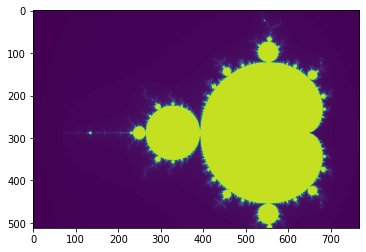

In [16]:
plt.imshow(frames[0])

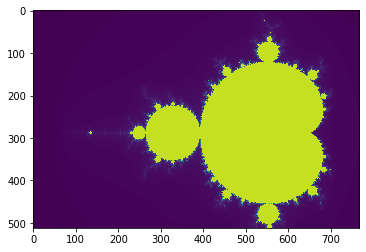

In [24]:
#frames = np.load(f'frames_{FPS}_{NUM_SEC}.npy')

from PIL import Image

im = plt.imshow(frames[0], interpolation='none')

for i, frame in enumerate(frames):
    c_frame = 255 * im.cmap(im.norm(frame))
    c_frame = np.delete(c_frame, -1, axis=2).astype(np.uint8)
    image = Image.fromarray(c_frame)
    image.save(f'frames/frame_{i:05}.png')